In [2]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import platform
#import SIRD_Model_Experimental
import SIRD_Model
from sklearn import linear_model

def loadData(filename):
    csvfile=open(filename, newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    for lv in rd: #generating the data matrix
        data.append(lv)
    header = data[0] #get the labels
    infectionData=(data[1:]) #data without the labels
    infectionData = np.array(infectionData)
    dates = infectionData[:,header.index("Dates")]
    infected = infectionData[:,header.index("Infected")]
    recovered = infectionData[:,header.index("Recovered")]
    deaths = infectionData[:,header.index("Deaths")]
    vacc = infectionData[:,header.index("Vaccinated")]
    vacc = vacc.astype(float)
    deaths = deaths.astype(float)
    recovered = recovered.astype(float)
    infected = infected.astype(float)
    return dates, infected, recovered, deaths, vacc



def getPop(state):
    path="../Data/"
    csvfile=open(path+"2020 Population Data.csv", newline='', encoding='UTF-8')
    rd = csv.reader(csvfile, delimiter=',')
    data=[]
    
    for lv in rd: #generating the data matrix
        data.append(lv)
    aData=(data[3:])
    for i in range(len(aData)):
        if state in aData[i][0]:
            pop = float(aData[i][1]) * 1000000
    return pop

def approxRecovered(infect,dead):
    recovG = np.zeros(len(infect))
    for i in range(len(infect) - 14):
        recovG[i + 14] = infect[i] - dead[i + 14]
    return recovG




pathc="../Data/Vaccination Data/State Data With Vaccinations/"
# modify the path syntax based on the current platform

filename = "CA.csv"


pop = getPop("California")

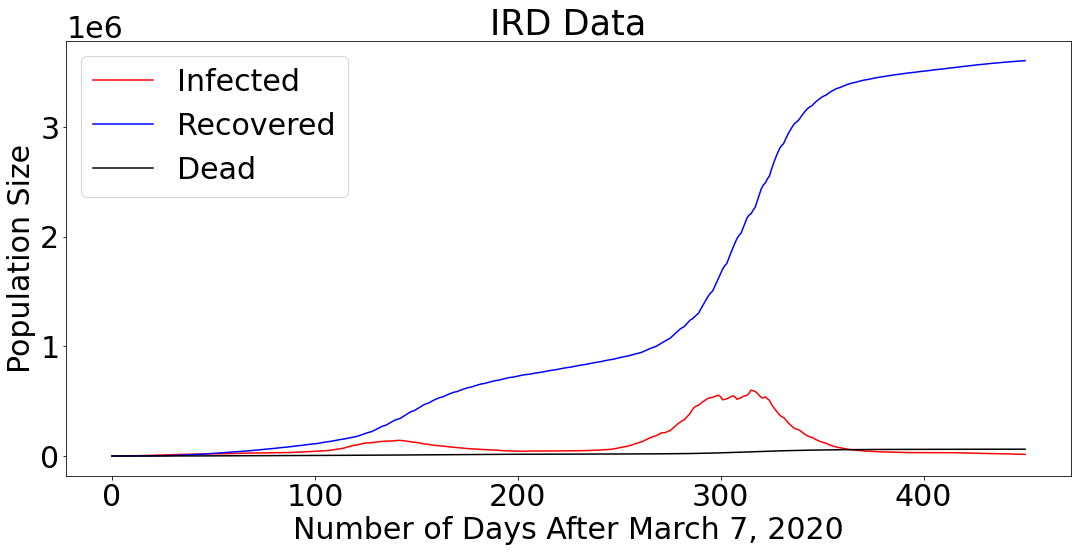

In [10]:
dates, infectRaw, recovRaw, deadRaw, vaccRaw = loadData(pathc + filename)

recov = approxRecovered(infectRaw, deadRaw)
infectRaw = infectRaw - recov - deadRaw


fig, ax = plt.subplots(figsize = (18,8))
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=30)
ax.plot(infectRaw, color = 'red', label = 'Infected')
ax.plot(recov, color = 'blue', label = 'Recovered')
ax.plot(deadRaw, color = 'black', label = 'Dead')
ax.legend(fontsize = 30)

ax.set_title('IRD Data', fontsize = 35)
ax.set_xlabel('Number of Days After March 7, 2020', fontsize = 30)
ax.set_ylabel('Population Size', fontsize = 30)

plt.savefig("../Figures/IRD Graph.png", dpi=600, facecolor='w', edgecolor='w',orientation='portrait', format="png",transparent=False, bbox_inches=None, pad_inches=0.1, metadata=None)